In [10]:
import torch
from create_answer_vocab import answer_vocab, ans2idx

In [2]:
from VizWizDataset import VizWizDataset

In [3]:
from VizWizAnswerModel import VizWizAnswerModel

In [4]:
def custom_collate_fn(batch):
    image_feats, text_feats, targets, answers = zip(*batch)

    image_feats = torch.stack(image_feats)
    text_feats = torch.stack(text_feats)
    targets = torch.stack(targets)

    # answers is a tuple of length batch_size, where each element is a list of answers
    return image_feats, text_feats, targets, answers


import json
# Load train data
with open("train.json", "r") as f:
    train_data = json.load(f)

# Load val data
with open("val.json", "r") as f:
    val_data = json.load(f)

train_dataset = VizWizDataset(train_data, answer_vocab, ans2idx,feature_dir="train_features", text_dir="train_questions" ,is_train=True)
val_dataset = VizWizDataset(val_data, answer_vocab, ans2idx, feature_dir="val_features", text_dir="val_questions", is_train=True)  # We do have answers for val
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_fn)




In [5]:
def soft_cross_entropy(preds, targets):
    return -torch.mean(torch.sum(targets * torch.log(preds + 1e-10), dim=1))

def compute_vizwiz_accuracy(pred_idx, answer_objects):
    # pred_answer = answer_vocab[pred_idx]
    pred_answer = next((k for k, v in ans2idx.items() if v == pred_idx), None)
    matches = sum(1 for obj in answer_objects 
                  if obj.strip().lower() == pred_answer)
    return min(1.0, matches / 3)


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VizWizAnswerModel(len(answer_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

epochs = 7
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
 
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        # Save the model
    
        torch.save(model.state_dict(), "vizwiz_model_VM1.pth")
        print(f"Model saved as vizwiz_model_VM1.pth at validation accuracy f{best_val_accuracy}.")



/home/radheshyamrouth/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch 1/7 | Train Loss: 4.8309 | Train Acc: 0.5083 | Val Loss: 4.0033 | Val Acc: 0.5991
Model saved as vizwiz_model_VM1.pth at validation accuracy f0.5991356023770941.
Epoch 2/7 | Train Loss: 3.8567 | Train Acc: 0.5555 | Val Loss: 3.8194 | Val Acc: 0.6156
Model saved as vizwiz_model_VM1.pth at validation accuracy f0.6155745928841562.
Epoch 3/7 | Train Loss: 3.3155 | Train Acc: 0.5823 | Val Loss: 3.7369 | Val Acc: 0.6231
Model saved as vizwiz_model_VM1.pth at validation accuracy f0.6230608937254004.
Epoch 4/7 | Train Loss: 2.8695 | Train Acc: 0.6111 | Val Loss: 3.7177 | Val Acc: 0.6280
Model saved as vizwiz_model_VM1.pth at validation accuracy f0.628000308713438.
Epoch 5/7 | Train Loss: 2.4639 | Train Acc: 0.6425 | Val Loss: 3.7618 | Val Acc: 0.6292
Model saved as vizwiz_model_VM1.pth at validation accuracy f0.629157984101259.
Epoch 6/7 | Train Loss: 2.1012 | Train Acc: 0.6804 | Val Loss: 3.7825 | Val Acc: 0.6356
Model saved as vizwiz_model_VM1.pth at validation accuracy f0.635563787913

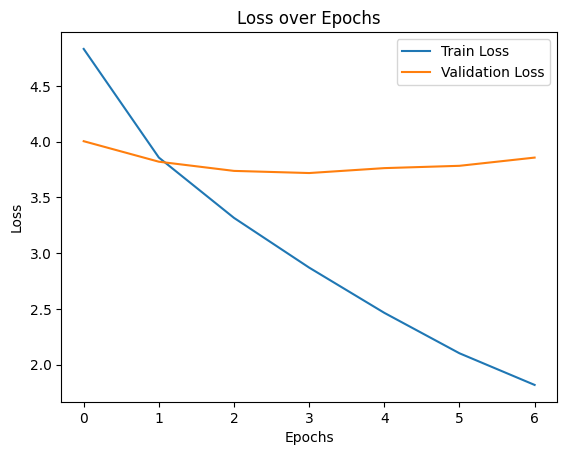

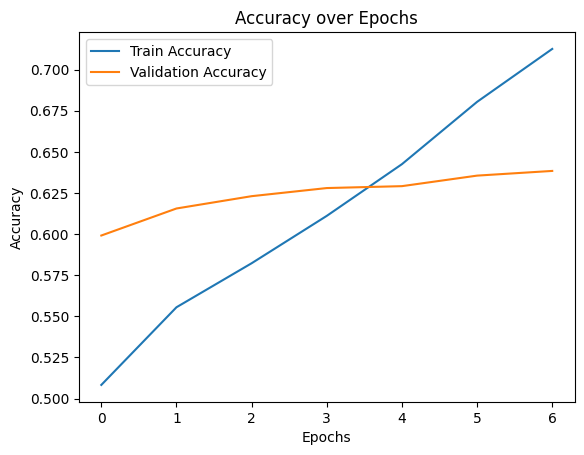

In [7]:
import matplotlib.pyplot as plt

# Loss Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy Plot
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [8]:
from VizWizAnswerModel_wod import VizWizAnswerModel

In [9]:
def custom_collate_fn(batch):
    image_feats, text_feats, targets, answers = zip(*batch)

    image_feats = torch.stack(image_feats)
    text_feats = torch.stack(text_feats)
    targets = torch.stack(targets)

    # answers is a tuple of length batch_size, where each element is a list of answers
    return image_feats, text_feats, targets, answers


import json
# Load train data
with open("train.json", "r") as f:
    train_data = json.load(f)

# Load val data
with open("val.json", "r") as f:
    val_data = json.load(f)

train_dataset = VizWizDataset(train_data, answer_vocab, ans2idx,feature_dir="train_features", text_dir="train_questions" ,is_train=True)
val_dataset = VizWizDataset(val_data, answer_vocab, ans2idx, feature_dir="val_features", text_dir="val_questions", is_train=True)  # We do have answers for val
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_fn)

def soft_cross_entropy(preds, targets):
    return -torch.mean(torch.sum(targets * torch.log(preds + 1e-10), dim=1))

def compute_vizwiz_accuracy(pred_idx, answer_objects):
    # pred_answer = answer_vocab[pred_idx]
    pred_answer = next((k for k, v in ans2idx.items() if v == pred_idx), None)
    matches = sum(1 for obj in answer_objects 
                  if obj.strip().lower() == pred_answer)
    return min(1.0, matches / 3)



In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VizWizAnswerModel(len(answer_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# For plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for image_feat, text_feat, target, answer_objects in train_loader:
        image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
        
        # Forward pass
        probs = model(image_feat, text_feat)
        # print(target.size())
        
        loss = soft_cross_entropy(probs, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_train_loss += loss.item() * image_feat.size(0)

        # Accuracy calculation per sample
        preds = torch.argmax(probs, dim=1)
        # print(preds)
        # print(len(preds))
        # print(answer_objects)
        # s = answer_objects
        # print(len(s))
        for i in range(len(preds)):
            # print(preds[i].item())
            # pred_answer = next((k for k, v in ans2idx.items() if v == preds[i].item()), None)
            # print(pred_answer)
            # print(answer_objects[i])
            correct_train += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
            total_train += 1

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for image_feat, text_feat, target, answer_objects in val_loader:
            image_feat, text_feat, target = image_feat.to(device), text_feat.to(device), target.to(device)
            #print("image",image_feat.size())
            #print("text",text_feat.size())
            probs = model(image_feat, text_feat)
            loss = soft_cross_entropy(probs, target)
            epoch_val_loss += loss.item() * image_feat.size(0)

            preds = torch.argmax(probs, dim=1)
            for i in range(len(preds)):
                correct_val += compute_vizwiz_accuracy(preds[i].item(), answer_objects[i])
                total_val += 1

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")
 
    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        # Save the model
    
        torch.save(model.state_dict(), "vizwiz_model_VM2.pth")
        print(f"Model saved as vizwiz_model_VM2.pth at validation accuracy f{best_val_accuracy}.")



Epoch 1/20 | Train Loss: 4.5014 | Train Acc: 0.5280 | Val Loss: 3.7990 | Val Acc: 0.6041
Model saved as vizwiz_model_VM2.pth at validation accuracy f0.6040750173651318.
Epoch 2/20 | Train Loss: 2.6777 | Train Acc: 0.6176 | Val Loss: 3.6642 | Val Acc: 0.6192
Model saved as vizwiz_model_VM2.pth at validation accuracy f0.619201975765996.
Epoch 3/20 | Train Loss: 1.6432 | Train Acc: 0.7511 | Val Loss: 3.7854 | Val Acc: 0.6098
Epoch 4/20 | Train Loss: 1.2283 | Train Acc: 0.8534 | Val Loss: 3.9788 | Val Acc: 0.6295
Model saved as vizwiz_model_VM2.pth at validation accuracy f0.6294666975380109.
Epoch 5/20 | Train Loss: 1.1184 | Train Acc: 0.8748 | Val Loss: 4.0683 | Val Acc: 0.6205
Epoch 6/20 | Train Loss: 1.0711 | Train Acc: 0.8875 | Val Loss: 4.0783 | Val Acc: 0.6270
Epoch 7/20 | Train Loss: 1.0206 | Train Acc: 0.8934 | Val Loss: 4.1033 | Val Acc: 0.6241
Epoch 8/20 | Train Loss: 0.9858 | Train Acc: 0.8977 | Val Loss: 4.1713 | Val Acc: 0.6193
Epoch 9/20 | Train Loss: 0.9550 | Train Acc: 0.90